In [45]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jul  2 19:13:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [46]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


Data Preparation and Feature Exploration

In [47]:
%pip install dask

In [48]:
%pip install scikit-learn

In [49]:
%pip install -U dataprep

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.special import logit
import lightgbm as lgb

Read Data

In [51]:

train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Santander Kaggle Challenge/Data Raw/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Santander Kaggle Challenge/Data Raw/test.csv')
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


Initial Cleaning

In [52]:
if( not train_df.isnull().sum().any() ):
  print("Dataframe has no missing values")
else:
  print("Dataframe has missing values")




Dataframe has no missing values


In [53]:
if (train_df.duplicated().sum() == 0):
  print("Dataframe has NO duplicated values")
else:
  print("Dataframe has duplicated values")

Dataframe has NO duplicated values


Detect and remove outliers

Filter for high correlation with target variable

<ipython-input-54-f5f8ba938e9d>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = train_df.corr()['target'].drop('target')


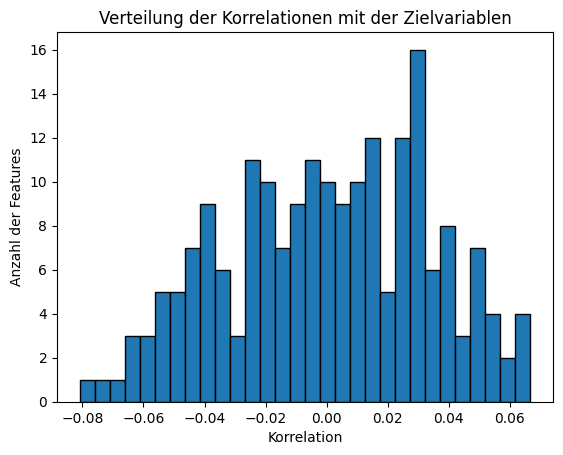

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# correlation of every column with target column (excluding target-target-correlation)
correlations = train_df.corr()['target'].drop('target')

#  visualize
plt.hist(correlations, bins=30, edgecolor='k')
plt.xlabel('Korrelation')
plt.ylabel('Anzahl der Features')
plt.title('Verteilung der Korrelationen mit der Zielvariablen')
plt.show()


Check for class imbalance

In [55]:
print(train_df['target'].value_counts())

0    179902
1     20098
Name: target, dtype: int64


Handle imbalance with SMOTE

In [56]:
from imblearn.over_sampling import SMOTE

In [57]:
smote = SMOTE(random_state=42)

#split into features and target for resampling
X = train_df.drop(['target', 'ID_code'], axis=1)
y = train_df['target']

X_resampled, y_resampled = smote.fit_resample(X, y)

train_df_prepared = pd.concat([train_df['ID_code'],X_resampled, y_resampled], axis=1)

In [58]:
print(train_df_prepared.columns)

Index(['ID_code', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5',
       'var_6', 'var_7', 'var_8',
       ...
       'var_191', 'var_192', 'var_193', 'var_194', 'var_195', 'var_196',
       'var_197', 'var_198', 'var_199', 'target'],
      dtype='object', length=202)


The next section shows some feature engineering techniques which I saw on kaggle for this challenge: It's about adding another column for each feature. This extra column tells if a value is unique or not.

In [59]:
print("Rows in resampled train_df_prepared are", train_df_prepared.shape[0])#should have more than 200000 rows due to resampling with SMOTE
train_df_prepared.head()

Rows in resampled train_df_prepared are 359804


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,target
0,train_0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914,0
1,train_1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518,0
2,train_2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965,0
3,train_3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996,0
4,train_4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104,0


In [60]:
test_df.head()


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [61]:
train_df_prepared.drop(['target'], axis=1).shape

(359804, 201)

In [62]:
"code snippet from https://www.kaggle.com/code/cardata/santander-customer-transaction"

# Assuming train_df and test_df are already defined and loaded
features = [x for x in train_df.columns if x.startswith("var")]
hist_df = pd.DataFrame()

for var in features:
    var_stats = pd.concat([train_df[var], test_df[var]]).value_counts()
    hist_df[var] = pd.Series(test_df[var]).map(var_stats)
    hist_df[var] = hist_df[var] > 1

ind = hist_df.sum(axis=1) != len(features)

var_stats = {var: pd.concat([train_df[var], test_df[ind][var]]).value_counts() for var in features}


<ipython-input-62-293208138599>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hist_df[var] = pd.Series(test_df[var]).map(var_stats)
<ipython-input-62-293208138599>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hist_df[var] = pd.Series(test_df[var]).map(var_stats)
<ipython-input-62-293208138599>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-

Expanding the existing training and testing dataframe with columns created by featrue extraction

In [63]:
expanded_train_df = train_df.copy()
expanded_test_df = test_df.copy()

for var in features:
    expanded_train_df[f"{var}_unique"] = expanded_train_df[var].map(var_stats[var]).fillna(1)
    expanded_test_df[f"{var}_unique"] = expanded_test_df[var].map(var_stats[var]).fillna(1)

<ipython-input-63-237a837d0ff9>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  expanded_train_df[f"{var}_unique"] = expanded_train_df[var].map(var_stats[var]).fillna(1)
<ipython-input-63-237a837d0ff9>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  expanded_train_df[f"{var}_unique"] = expanded_train_df[var].map(var_stats[var]).fillna(1)
<ipython-input-63-237a837d0ff9>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider j

In [64]:
print("Rows in expanded train_df are", expanded_train_df.shape[0])
expanded_train_df.head()

Rows in expanded train_df are 200000


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190_unique,var_191_unique,var_192_unique,var_193_unique,var_194_unique,var_195_unique,var_196_unique,var_197_unique,var_198_unique,var_199_unique
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,3,8,9,4,9,5,5,14,5,2
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,8,5,9,2,4,4,4,21,6,2
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,4,5,6,2,2,2,3,12,4,2
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,2,3,6,4,4,8,5,4,2,2
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,3,8,1,1,1,9,5,9,2,2


In [65]:
print("Rows in expanded test_df are", expanded_test_df.shape[0])
expanded_test_df.head()

Rows in expanded test_df are 200000


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190_unique,var_191_unique,var_192_unique,var_193_unique,var_194_unique,var_195_unique,var_196_unique,var_197_unique,var_198_unique,var_199_unique
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,2,2,2,7,2,3,5,4,4,4
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,2,6,8,1,4,18,2,11,3,3
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,2,3,9,2,4,2,1,3,2,1
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,3,2,7,3,4,4,2,10,7,1
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,3,4,8,4,5,11,2,4,2,3


shows that the correlations are very small.

2 Possibilities from here on:
- 1) Deep Learning
- 2) More Feature engineering

in any case, data has to be scaled and saved:

In [66]:

#removing everything that cannot be scaled (stirings)
X_train = expanded_train_df.drop(['target', 'ID_code'], axis=1)
y_train = expanded_train_df['target']

X_test = expanded_test_df.drop(['ID_code'], axis=1)


In [67]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [68]:
print(type(X_test_scaled))

<class 'numpy.ndarray'>


Write to csv file

In [69]:
pd.concat([pd.DataFrame(X_train_scaled, columns=X_train.columns), y_train.reset_index(drop=True)], axis=1).to_csv('/content/drive/MyDrive/Colab Notebooks/Santander Kaggle Challenge/Data Preprocessed/preprocessed_train_data.csv', index=False)
pd.DataFrame(X_test_scaled, columns=X_test.columns).to_csv('/content/drive/MyDrive/Colab Notebooks/Santander Kaggle Challenge/Data Preprocessed/preprocessed_test_data.csv', index=False)
